In [1]:
# import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gribscan
import matplotlib.cm as cm

# Wave model WAM output from IFS

### Load wave data with open_zarr(), time, lon, lat

In [2]:
# json file was already prepared with gribscan-index and gribscan-build command line tools
resolution='tco2559-ng5'
gribfiles='wam_output/WAMc2' 
datapath='/work/bm1235/a270046/cycle2-sync/'+resolution+'/'+gribfiles
datazarr=datapath+'/json.dir/atm2d.json' # all wave data, this is the whole May
data = xr.open_zarr("reference::"+datazarr, consolidated=False)
#data = xr.open_zarr("reference::"+'/work/bm1235/a270046/cycle2-sync/'+resolution+'/wam_output/WAMc2/json.dir/atm2d.json', consolidated=False)




In [5]:
#note that there is currently no data before 2020-05-01. If you try to access data before that date, you may get only nans or simply an error.
data

<xarray.Dataset>
Dimensions:  (time: 6170, value: 2612294)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(2612294,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables:
    cdww     (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    dwi      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    mwd      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    mwp      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    pp1d     (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    swh      (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
    wind     (time, value) float64 dask.array<chunksize=(1, 2612294), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

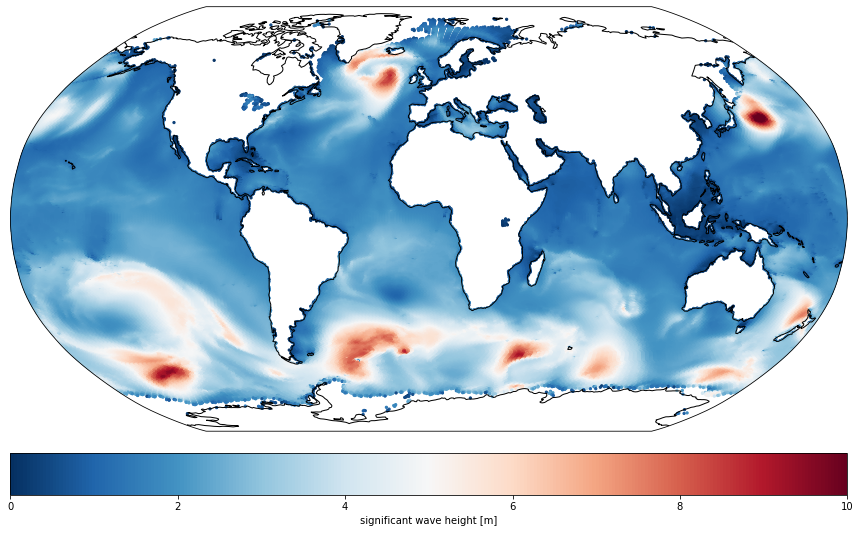

In [4]:
# sstep controls the spacing between points to plot
sstep=10 # (10 with s=4 e.g.)
#pick a certain 
data_sample=data.swh.sel(time='2020-05-01T00:00:00.000000000')
# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.

ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')

sc=ax.scatter(data.lon[::sstep],data.lat[::sstep],c=data_sample[::sstep],s=5,cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), vmin=0.,vmax=10.)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label('significant wave height [m]')


Follow different route here: interpolate example file "source "with metview macro, resulting in "output.nc" on regular Gaussian grid. Convert to netcdf and plot

In [28]:
model_lon = datanc.longitude.values
model_lat = datanc.latitude.values
data_sample = datanc.swh.sel(time='2020-06-01')

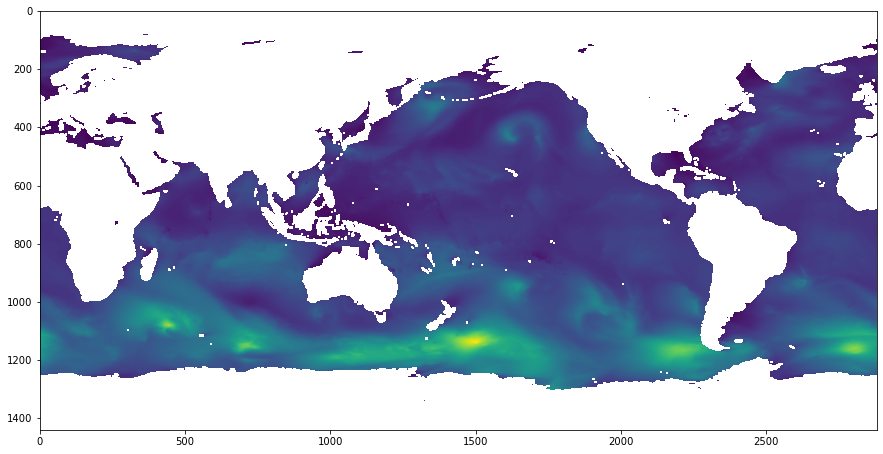

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(data_sample)

In [35]:
data_sample, np.shape(model_lon), np.shape(model_lat)

(<xarray.DataArray 'swh' (latitude: 1441, longitude: 2880)>
 dask.array<getitem, shape=(1441, 2880), dtype=float32, chunksize=(1441, 2880), chunktype=numpy.ndarray>
 Coordinates:
   * longitude  (longitude) float32 0.0 0.125 0.25 0.375 ... 359.6 359.8 359.9
   * latitude   (latitude) float32 90.0 89.88 89.75 89.62 ... -89.75 -89.88 -90.0
     time       datetime64[ns] 2020-06-01
 Attributes:
     units:      m
     long_name:  Significant height of combined wind waves and swell,
 (2880,),
 (1441,))

In [45]:
LON, LAT = np.meshgrid(model_lon, model_lat)

In [46]:
np.min(LAT), np.max(LAT), np.min(LON), np.max(LON)

(-90.0, 90.0, 0.0, 359.875)

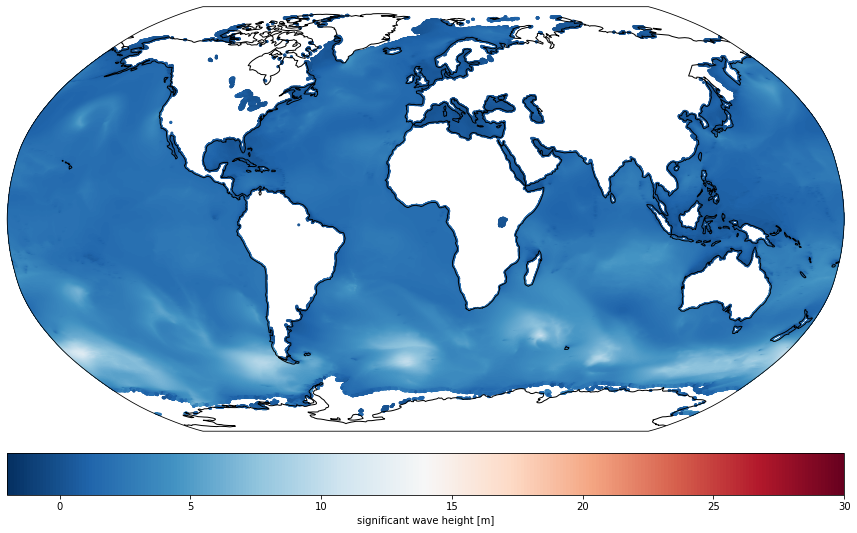

In [56]:
# sstep controls the spacing between points to plot
sstep=1 # (10 with s=4 e.g.)

# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')

sc=ax.scatter(LON[::sstep], LAT[::sstep], s=4 , c=data_sample[::sstep],cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), vmin=-2.,vmax=30.)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label('significant wave height [m]')
#plt.clim(-20, 29.) 